****************************************************************
# Neural Networks for Event Classification
****************************************************************

In this tutorial we train a Long Short Term Memory neural network to distriminate absorber and carrier recoil events.

A neural network is a supervised, non-linear fit model, capable of fitting high dimensional and complex correlations. Input and output is always a one dimensional vector. The Long Short Term Memory neural network processes input data in a time-distributed fashion, by splitting the input vector in smaller ones, called time steps. It reuses its fit parameters for every time step, while storing two gate-protected state vectors internally, that represent long- and short term correlations between time steps. This network type is especially suitable for the processing for time distributed data, as ours.

For the neural networks we use the PyTorch framework, that is the most used framework within the research community. We also use the API of PyTorch Lighning, that reduces the code bulk inside training files significantly and increases the flexibility, while keeping all possibilities to add individual elements to the training process.

In [1]:
import numpy as np
import cait as ai
from pytorch_lightning import Trainer
from torchvision import transforms
import h5py
from cait.datasets import RemoveOffset, Normalize, DownSample, ToTensor, CryoDataModule
from cait.models import LSTMModule, nn_predict
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

The parameter here might seem a bit overwhelming. We try to explain them with the comments next to each.

In [2]:
# some parameters
# nmbr_gpus = ... uncommment and put in trainer to use GPUs
path_h5 = 'test_data/labeled_001.h5'
type = 'events'  # the group key for the data in the HDF5 set
keys = ['event', 'labels']  # the datasets in the group from which we include data in the samples for the NN
channel_indices = [[0], [0]]  # the first indices of the datasets
feature_indices = [None, None]  # the third indices of the datasets
feature_keys = ['event_ch0']    # the keys in the samples of the NN dataset that are input to the NN
                                # in the data set for the NN, the keys have additionally appended the channel index 
label_keys = ['labels_ch0']  # the keys in the samples of the NN dataset that are labels to the NN
norm_vals = {'event_ch0': [0, 3]}  # we do a min - max normalization of all samples, so these are roughly the lowest and highest values of the events in the data set
down_keys = ['event_ch0']  # if we input the raw time series, we apply downsampling first
down = 64                  # all samples in the NN dataset with the indices specified above are by the factor down downsampled
input_size = 8  # the input size of the LSTM cell
nmbr_classes = 10  # the number of classes in the data set - attention - the class index of the carrier event is 8, therefore we need at least 9 classes, even though one two of them are present in our data set
max_epochs = 30  # the maximal trianing epochs of the neural network
save_naming = 'lstm-clf'  # the name adition if we want to save the trained model

## Dataset and Model

We define several transforms that are done on all data input to the NN. First, this is to remove the offset of the raw time series, then the samples are min-max normalized. If we choose to do a downsampling of the raw data, this is done before the numpy arrays of the samples are converted to PyTorch tensors.

In [3]:
# create the transforms
transforms = transforms.Compose([RemoveOffset(keys=feature_keys),
                                 Normalize(norm_vals=norm_vals),
                                 DownSample(keys=down_keys, down=down),
                                 ToTensor()])

The CryoDataModule is a Cait-specific child of Pytorch Lightnings DataModule class. It puts the data from the HDF5 file into a format, that can be input to the NN. The data is still loaded lazy, to prevent memory issues.

In [4]:
# create data module and init the setup
dm = CryoDataModule(hdf5_path=path_h5,
                    type=type,
                    keys=keys,
                    channel_indices=channel_indices,
                    feature_indices=feature_indices,
                    transform=transforms)

With the prepare_data routine we define several facts about the training process. This is especially the split sizes of training, validation and test sets and the batch size. Here we can also specify the number of workers if we want to do multithreading in the training process. Try both arguments 0 and the number of your CPUs for the key nmbr_workers!

In [5]:
dm.prepare_data(val_size=0.2,
                test_size=0.2,
                batch_size=32,
                dataset_size=None,
                nmbr_workers=0,  # set to number of CPUS on the machine (strange fact: for me 0 is faster than 8?) probabily inefficient implementation of our dataset for multithreading (issue on GitLab is open)
                only_idx=None,
                shuffle_dataset=True,
                random_seed=21,
                feature_keys=feature_keys,
                label_keys=label_keys,
                keys_one_hot=label_keys)

The setup method does internal definitions and preprocessing of the data. The difference to the prepare_data routine is, that it is called on each worker separately.

In [6]:
dm.setup()

Now we define the LSTM neural network model, as a child of the LightningModule. We need to specify the architecture of the model (layers, etc), as well as the learning rate, i.e. the size of weight updates in the optimization process. If the training does not work, it very often comes down to a wrong learning rate!

In [7]:
# create lstm clf
lstm = LSTMModule(input_size=input_size,
                  hidden_size=input_size * 10,
                  num_layers=2,
                  seq_steps=int(dm.dims[1] / input_size),  # downsampling is already considered in dm
                  device_name='cpu',
                  nmbr_out=nmbr_classes,  # this is the number of labels
                  lr=1e-3,
                  label_keys=label_keys,
                  feature_keys=feature_keys,
                  is_classifier=True,
                  down=down,
                  down_keys=feature_keys,
                  norm_vals=norm_vals,
                  offset_keys=feature_keys)

## Tensorboard

Tensorboard is a convenient and powerful tool for the visualization of neural network trainings. It can be display inline in a Jupyter notebook or in a webbrowser when called from a terminal. The folder lightning_logs will be created automatically and store data of the training process.

.. code:: python

    %load_ext tensorboard
    %tensorboard --logdir=lightning_logs

If you run scripts on servers without X-forwarding, you can still run Tensorboard on the server and listen to the sending port on your local machine. For this, include the -L flag when connecting to the server, as shown below.

.. code:: console

    ssh -L 16006:127.0.0.1:6006 <SERVER_SSH_ADRESS>
    
You can then open Tensoreboard in your local webbrowser with the URL http://127.0.0.1:16006.

## Training

In the training of the NN we use a trick, namely we save the model with the lowest loss value on the validation set. This is the best possible estimator for the loss value on the test set and therefore also for the performance on unseen data.

In [8]:
# create callback to save the best model
checkpoint_callback = ModelCheckpoint(dirpath='callbacks',
                                      monitor='val_loss',
                                      filename=save_naming + '-{epoch:02d}-{val_loss:.2f}')

The Pytorch Lightning Trainer class takes care of the whole training process under the hood. We pass the number of epochs and the checkpoints as arguments. Here we could also specify to use GPUs, if we have any.

In [9]:
# create instance of Trainer
trainer = Trainer(max_epochs=max_epochs,
                  callbacks=[checkpoint_callback])
# keyword gpus=nmbr_gpus for GPU Usage
# keyword max_epochs for number of maximal epochs

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Now we start the training of our model.

In [10]:
# all training happens here
trainer.fit(model=lstm,
            datamodule=dm)


  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 80 K  
1 | fc1  | Linear | 25 K  
/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

## Evaluation

Having finished the training, we load the best saved model from out checkpoint for the evaluation.

In [11]:
# load best model
lstm.load_from_checkpoint(checkpoint_callback.best_model_path)

LSTMModule(
  (lstm): LSTM(8, 80, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=2560, out_features=10, bias=True)
)

The trainer has stored the path to the test set internally, so we can test our model.

In [12]:
# run test set
result = trainer.test()
print(result)

/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0.0294),
 'train_loss': tensor(0.0042),
 'val_loss': tensor(0.0177)}
--------------------------------------------------------------------------------

[{'train_loss': 0.004193923436105251, 'val_loss': 0.017693398520350456, 'test_loss': 0.029421286657452583}]


The loss value does not say much about the performance of our model in terms of classification accuracy. So we start a per-hand evaluation below.

In [13]:
# predictions with the model are made that way
f = h5py.File(dm.hdf5_path, 'r')
test_idx = dm.test_sampler.indices
test_idx.sort()
x = {feature_keys[0]: f[type][keys[0]][channel_indices[0][0], test_idx]}  # array of shape: (nmbr_events, nmbr_features)
y = np.array(f[type][keys[1]][channel_indices[1][0], test_idx])
prediction = lstm.predict(x).numpy()

# predictions can be saved with instance of EvaluationTools
print('PREDICTION: ', prediction)
print('ACCURACY: ', np.sum(prediction == y)/len(y))
print('Best model: ', checkpoint_callback.best_model_path)

PREDICTION:  [8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 8 1 1 1 1 1 1 1 1 1 1 1 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
ACCURACY:  0.99
Best model:  /Users/felix/PycharmProjects/cait/docs/source/tutorials/callbacks/lstm-clf-epoch=26-val_loss=0.01.ckpt


The score on the test set pretty good, it seems that our model learned something!

## Predictions on Real Data

We ultimately want to include predictions of our neural network model to the HDF5 set, in order to use it for quality cuts in the analysis process. For this we can use the function nn_predict with the according arguments.

In [14]:
# include the predictions in another HDF5 file
nn_predict(h5_path='test_data/test_001.h5',
           model=lstm,
           feature_channel=0,
           group_name='events',
           prediction_name='pred_lstm',
           keys=['event'],
           no_channel_idx_in_pred=False)


pred_lstm written to file test_data/test_001.h5.


We don't have labels for an exact evaluation in out raw data set, so we need another method for evaluation. For this we do a plot of the decay times of the pulses, because we learned in a previous notebook that this is a good discriminative quantity.

In [15]:
dh = ai.DataHandler(channels=[0,1])
dh.set_filepath(path_h5='test_data/',
                fname='test_001',
                appendix=False)

ph = dh.get('events', 'mainpar')[0,:,0]
decay_time = (dh.get('events','mainpar')[0,:,6] - dh.get('events','mainpar')[0,:,4])/dh.sample_frequency
pred_lstm = dh.get('events', 'pred_lstm')[0]
pred_absorber = ai.cuts.LogicalCut(pred_lstm == 1)
pred_carrier = ai.cuts.LogicalCut(pred_lstm == 8)

DataHandler Instance created.


Looks like the neural network gets almost all of our events in the raw data right! For disclosure we have to mention, that our used dataset is rather small for neural network training, were datasets contain usually at least several thousand of samples. So this accuracy can surely be improved. In previous work, discrimination thresholds in the order of magnitude of the baseline resolution could be achieved.

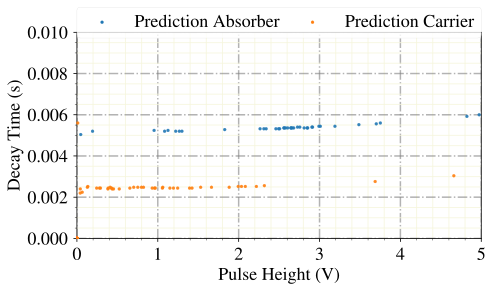

In [16]:
plt.close()
ai.styles.use_cait_style(dpi=150)
plt.scatter(ph[pred_absorber.get_flag()], decay_time[pred_absorber.get_flag()], marker='.', alpha=0.9, zorder=10, label='Prediction Absorber')
plt.scatter(ph[pred_carrier.get_flag()], decay_time[pred_carrier.get_flag()], marker='.', alpha=0.9, zorder=10, label='Prediction Carrier')
ai.styles.make_grid()
plt.xlabel('Pulse Height (V)')
plt.ylabel('Decay Time (s)')
plt.xlim([0,5])
plt.ylim([0,0.01])
legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), mode="expand", borderaxespad=0., ncol=3)
for lh in legend.legendHandles:
    lh.set_alpha(1.0)
plt.show()

Please forward questions and correspondence about this notebook to felix.wagner(at)oeaw.ac.at.